In [47]:
# Check if the data is correctly loaded
%load_ext autoreload
%autoreload 2
from geomoka.dataloader.dataset import GenericDataset
from tqdm import tqdm
from util.draw import DrawSegmentation

# WARNING: remove ../ from the paths in config, as the code is run from the root directory of the project
root_dir = '../dataset/isprs_postdam'
train_csv = '../dataset/isprs_postdam/splits/train.csv'
val_csv = '../dataset/isprs_postdam/splits/val.csv'
test_csv = '../dataset/isprs_postdam/splits/test.csv'
metadata = '../config/isprs_postdam/metadata.yaml'

train_ds = GenericDataset(
    data_csv=train_csv,
    root_dir=root_dir,
    metadata=metadata,
)

val_ds = GenericDataset(
    data_csv=val_csv,
    root_dir=root_dir,
    metadata=metadata,
)

test_ds = GenericDataset(
    data_csv=test_csv,
    root_dir=root_dir,
    metadata=metadata,
)

print(f"Train dataset length: {len(train_ds)}")
print(f"Valid dataset length: {len(val_ds)}")
print(f"Test dataset length: {len(test_ds)}")

# Check for consistent input size
for ds in [train_ds ,val_ds, test_ds]:
    loop = tqdm(ds)
    prev_img, prev_mask = ds[0]
    for i, (img, mask) in enumerate(loop):
        assert img.shape == prev_img.shape, f"Inconsistent img size {ds.df.iloc[i]}"
        assert mask.shape == prev_mask.shape, f"Inconsistent mask size {ds.df.iloc[i]}"
        prev_img, prev_mask = img, mask

print(f"Image shape: {img.shape}")
print(f"Mask shape: {mask.shape}")

Train dataset length: 1680
Valid dataset length: 360
Test dataset length: 360


  0%|          | 0/1680 [00:00<?, ?it/s]

100%|██████████| 360/360 [00:05<00:00, 64.47it/s]

Image shape: (300, 300, 3)
Mask shape: (300, 300)


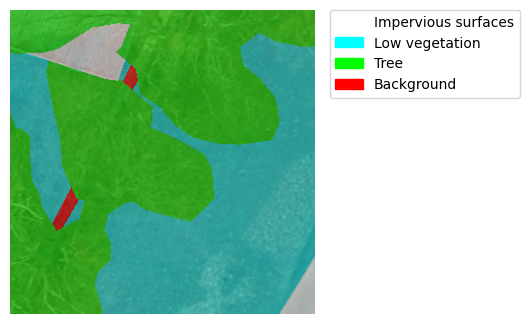

In [48]:
# Input shape
img, mask = test_ds[10]
draw = DrawSegmentation(metadata)
draw(img, mask, alpha=0.5)

In [49]:
# Model checker for correct output dimensions
import torch
from geomoka.model.build_model import build_segmentation_model

model_cfg = dict(
    model = 'dpt_dinov2_base',
    in_channels=3,
    nclass=5,
    lock_backbone=False,
    kwargs={}
)

model = build_segmentation_model(**model_cfg)

inp_dim = [4, 3, 28, 28]
out_dim = inp_dim.copy()
out_dim[1] = model_cfg['nclass']

inp = torch.rand(*inp_dim)
out = model(inp)

print(f"output should be in {out_dim} dimensions")
print("output shape: ", out.shape)

Pretrained DINOv2 dinov2_base weights already exists at /home/ubuntu/.cache/geomoka/pretrained/dinov2_base.pth. Skipping download.
Pretrained DINOv2 weights loaded from /home/ubuntu/.cache/geomoka/pretrained/dinov2_base.pth
Built dpt_dinov2_base model with 3 input channels and 5 classes with lock_backbone=False
output should be in [4, 5, 28, 28] dimensions
output shape:  torch.Size([4, 5, 28, 28])


In [67]:
%load_ext autoreload
# Check transormations
from geomoka.dataloader.wrapper import SupervisedDataset
from util.draw import DrawSegmentation
from util.draw import load_yaml

draw = DrawSegmentation(metadata)
metadata = '../config/isprs_postdam/metadata.yaml'
config = '../config/isprs_postdam/train_dpt.yaml'
cfg = load_yaml(config)

transform_cfg = cfg['transform_cfg']['train']
for trans in transform_cfg:
    if trans['name'] == 'Normalize':
        kwrags = trans.get('kwargs', {})
        draw.set_reverse_norm(mean=kwrags['mean'], std=kwrags['std'])
        break

train_loader = SupervisedDataset(train_ds, transform_cfg=transform_cfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


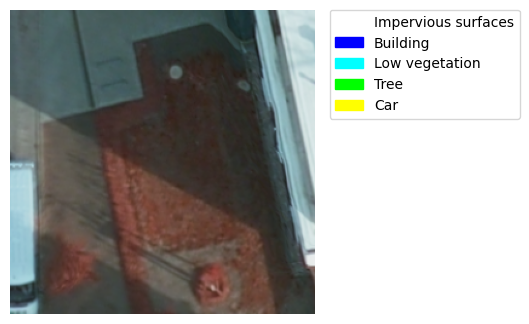

In [88]:
img, mask = train_loader[1]
draw(img, mask, alpha=0.0)